In [1]:
import os
import json
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

class CaptchaDatasetWithBBoxes(Dataset):
    def __init__(self, data_dir, transform=None):
        """
        Args:
            data_dir (string): Direct path to the specific data folder (train, val, or test)
            transform (callable, optional): Optional transform to be applied on images
        """
        self.data_dir = data_dir
        self.images_dir = os.path.join(self.data_dir, 'images')
        self.transform = transform
        
        self.image_list = sorted([f for f in os.listdir(self.images_dir) if f.endswith('.png')])
        
        # Load labels if available
        self.labels_dict = {}
        labels_file = os.path.join(self.data_dir, 'labels.json')
        if os.path.exists(labels_file):
            with open(labels_file, 'r') as f:
                labels = json.load(f)
                self.labels_dict = {item['image_id']: item for item in labels}
    
    def __len__(self):
        return len(self.image_list)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = self.image_list[idx]
        img_path = os.path.join(self.images_dir, img_name)
        
        # Load image as grayscale
        image = Image.open(img_path).convert('L')
        original_size = image.size  # (width, height)
        
        # Get image_id without extension
        image_id = os.path.splitext(img_name)[0]
        
        # Get labels if available
        label_info = self.labels_dict.get(image_id, {})
        
        # Extract captcha string and annotations
        captcha_string = label_info.get('captcha_string', '')
        annotations = label_info.get('annotations', [])
        
        # Process bounding boxes
        bboxes = []
        oriented_bboxes = []
        category_ids = []
        
        for annotation in annotations:
            # Regular bounding box [x1, y1, x2, y2]
            bbox = annotation.get('bbox', [])
            if bbox:
                bboxes.append(bbox)
            
            # Oriented bounding box [x1,y1,x2,y2,x3,y3,x4,y4]
            oriented_bbox = annotation.get('oriented_bbox', [])
            if oriented_bbox:
                oriented_bboxes.append(oriented_bbox)
            
            # Category ID (character class)
            category_id = annotation.get('category_id', -1)
            category_ids.append(category_id)
        
        # Convert to tensors
        bboxes = torch.tensor(bboxes, dtype=torch.float32) if bboxes else torch.empty((0, 4))
        oriented_bboxes = torch.tensor(oriented_bboxes, dtype=torch.float32) if oriented_bboxes else torch.empty((0, 8))
        category_ids = torch.tensor(category_ids, dtype=torch.long) if category_ids else torch.empty((0,), dtype=torch.long)
        
        # Apply transforms if specified
        if self.transform:
            image = self.transform(image)
        
        sample = {
            'image': image,
            'image_id': image_id,
            'captcha_string': captcha_string,
            'bboxes': bboxes,  # Regular bounding boxes
            'oriented_bboxes': oriented_bboxes,  # Oriented bounding boxes
            'category_ids': category_ids,  # Character category IDs
            'num_objects': len(annotations),  # Number of characters
            'original_size': original_size  # (width, height)
        }
        
        return sample

# Custom collate function for bounding boxes
def collate_fn_with_bboxes(batch):
    """Custom collate function to handle variable-length bounding boxes"""
    images = torch.stack([item['image'] for item in batch])
    image_ids = [item['image_id'] for item in batch]
    captcha_strings = [item['captcha_string'] for item in batch]
    
    # Keep bounding boxes as lists since they have variable lengths
    bboxes = [item['bboxes'] for item in batch]
    oriented_bboxes = [item['oriented_bboxes'] for item in batch]
    category_ids = [item['category_ids'] for item in batch]
    num_objects = [item['num_objects'] for item in batch]
    original_sizes = [item['original_size'] for item in batch]
    
    return {
        'image': images,
        'image_id': image_ids,
        'captcha_string': captcha_strings,
        'bboxes': bboxes,
        'oriented_bboxes': oriented_bboxes,
        'category_ids': category_ids,
        'num_objects': num_objects,
        'original_size': original_sizes
    }

# Helper function to create dataloaders with bboxes
def get_dataloader_with_bboxes(data_folder, batch_size=32, shuffle=True):
    """
    Create dataloader that includes bounding box information
    """
    # Define transformations
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
    ])
    
    # Create dataset
    dataset = CaptchaDatasetWithBBoxes(
        data_dir=data_folder,
        transform=transform
    )
    
    # Create dataloader with custom collate function
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=0,
        collate_fn=collate_fn_with_bboxes
    )
    
    return dataloader

# Visualization function with bounding boxes
def visualize_with_bboxes(batch, idx=0):
    """Visualize image with bounding boxes"""
    # Get image and denormalize
    img = batch['image'][idx].squeeze()
    img = img * 0.5 + 0.5  # Denormalize from [-1, 1] to [0, 1]
    
    # Get bounding boxes for this image
    bboxes = batch['bboxes'][idx]
    category_ids = batch['category_ids'][idx]
    captcha_string = batch['captcha_string'][idx]
    
    # Create figure
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    ax.imshow(img, cmap='gray')
    ax.set_title(f"CAPTCHA: {captcha_string}")
    
    # Draw bounding boxes
    for i, bbox in enumerate(bboxes):
        x1, y1, x2, y2 = bbox
        width = x2 - x1
        height = y2 - y1
        
        # Create rectangle
        rect = plt.Rectangle((x1, y1), width, height, 
                           linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        
        # Add category ID as text
        if i < len(category_ids):
            ax.text(x1, y1-5, f'ID: {category_ids[i].item()}', 
                   color='red', fontsize=10, weight='bold')
    
    ax.axis('off')
    plt.tight_layout()
    plt.show()
    
    print(f"Number of characters: {len(bboxes)}")
    print(f"Bounding boxes shape: {bboxes.shape}")
    print(f"Category IDs: {category_ids.tolist()}")

Batch size: 4
Image shape: torch.Size([4, 1, 160, 640])


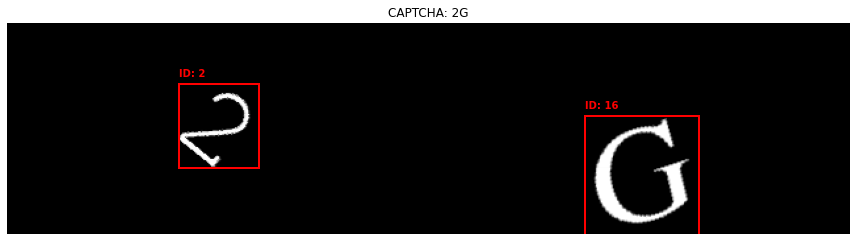

Number of characters: 2
Bounding boxes shape: torch.Size([2, 4])
Category IDs: [2, 16]
Image 0: '2G' has 2 characters
  Bboxes shape: torch.Size([2, 4])
Image 1: '346' has 3 characters
  Bboxes shape: torch.Size([3, 4])
Image 2: 'USB' has 3 characters
  Bboxes shape: torch.Size([3, 4])
Image 3: 'Z5A55S' has 6 characters
  Bboxes shape: torch.Size([6, 4])


In [2]:
import os

# Base path to the dataset
base_path = '/home/utn/abap44us/Downloads/UTN-CV25-Captcha-Dataset/part2'

# Create dataloaders with bounding boxes
train_loader_bbox = get_dataloader_with_bboxes(os.path.join(base_path, 'train'), batch_size=4, shuffle=True)

# Test the dataloader
for batch in train_loader_bbox:
    print(f"Batch size: {len(batch['captcha_string'])}")
    print(f"Image shape: {batch['image'].shape}")
    
    # Visualize first image with bounding boxes
    visualize_with_bboxes(batch, idx=0)
    
    # Print info about bounding boxes
    for i in range(len(batch['captcha_string'])):
        print(f"Image {i}: '{batch['captcha_string'][i]}' has {batch['num_objects'][i]} characters")
        print(f"  Bboxes shape: {batch['bboxes'][i].shape}")
    
    break

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# --- Weight Inititializeion with He-Method ) ---
def init_weights_kaiming(m):
    # use Kaiming init for conv/linear layers, set bias to zero
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    # batch/group norm: start with weight=1 and bias=0
    elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

#  Stem 
class Stem(nn.Module):
    """
    This is a small-image friendly stem that mimics the res-net18 style stem.

    Tradition ResNet stem:
        # self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=7, stride=2, padding=3, bias=False)
        # self.bn   = nn.BatchNorm2d(out_ch)
        # self.relu = nn.ReLU(inplace=True)
        # self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    Compared to traditional. resnet 18 this  replace 7x7 s2 + maxpool with 3×(3x3) conv stack and delay the first downsample.
    Goal: retain fineer details early in network
    """
    # def __init__(self, in_ch=3, out_ch=64):  # RGB input channels
    def __init__(self, in_ch=1, out_ch=64):    # Grayscale Input Channels
        super().__init__()

        # --- New small-image stem ---
        self.conv1 = nn.Conv2d(in_ch, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(32)
        self.act1  = nn.SiLU(inplace=True)  # see https://arxiv.org/pdf/1710.05941

        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(32)
        self.act2  = nn.SiLU(inplace=True)

        self.conv3 = nn.Conv2d(32, out_ch, kernel_size=3, stride=2, padding=1, bias=False)  # first downsample here
        self.bn3   = nn.BatchNorm2d(out_ch)
        self.act3  = nn.SiLU(inplace=True)

        # Initialize weights of conv layers via He_Init Strategy
        for m in [self.conv1, self.conv2, self.conv3]:
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        for b in [self.bn1, self.bn2, self.bn3]:
            nn.init.constant_(b.weight, 1.0)
            nn.init.constant_(b.bias, 0.0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.act3(x)
        return x  # 160x640 -> 80x320 (H×W)

#  Residual Block used for resnet
class ResidualBlock(nn.Module):
    expansion = 1
    def __init__(self, in_ch, out_ch, stride=1, dilation=1 , downsample=None):
        super().__init__()
        """
        [IMPROVEMENT] allow dilation to grow RF without more downsamples
        [IMPROVEMENT] SiLU activations for smoother gradients on OCR edges
        """
        padding = dilation
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride,
                               padding=padding, dilation=dilation, bias=False)
        self.bn1   = nn.BatchNorm2d(out_ch)
        self.act   = nn.SiLU(inplace=True)  # was ReLU

        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1,
                               padding=padding, dilation=dilation, bias=False)
        self.bn2   = nn.BatchNorm2d(out_ch)

        self.downsample = downsample   # <--- store it


        # Init
        for m in (self.conv1, self.conv2):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        nn.init.constant_(self.bn1.weight, 1.0); nn.init.constant_(self.bn1.bias, 0.0)
        nn.init.constant_(self.bn2.weight, 1.0); nn.init.constant_(self.bn2.bias, 0.0)

    def forward(self, x):
        identity = x

        out = self.act(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        if self.downsample is not None:   # <--- apply projection if needed
            identity = self.downsample(x)

        out += identity
        out = self.act(out)
        return out

# ---------- ResNet-18 Backbone ----------
class ResNet18Backbone(nn.Module):
    """
    Backbone only (no GAP/FC).

    Old vanilla scales (for 640x160 W×H) were deeper OS; we keep higher spatial detail:
      stem  (s2) -> 80x320
      layer1 (s1) -> 80x320
      layer2 (s2) -> 40x160
      layer3 (s1, dil=2) -> 40x160
      layer4 (s1, dil=2) -> 40x160   (256 ch)  <-- feed to your head(s)

    Goal: better localization of small characters while keeping receptive field via dilation.
    """
    def __init__(self, in_ch=1, return_p3=True):
        super().__init__()
        self.stem = Stem(in_ch=in_ch, out_ch=64)
        self.in_ch = 64
        self.return_p3 = return_p3

        # layer1: stride=1
        self.layer1 = self._make_layer(ResidualBlock, 64,  blocks=2, stride=1, dilation=1)

        # layer2: stride=2 (downsample to ~1/4 overall)
        self.layer2 = self._make_layer(ResidualBlock, 128, blocks=2, stride=2, dilation=1)

        # layer3: keep resolution (stride=1) but expand RF with dilation
        self.layer3 = self._make_layer(ResidualBlock, 256, blocks=2, stride=1, dilation=2)

        # layer4: same resolution (stride=1) with dilation
        self.layer4 = self._make_layer(ResidualBlock, 256, blocks=2, stride=1, dilation=2)  # slimmer tail (256)

    def _make_layer(self, block, out_ch, blocks, stride, dilation):
        down = None
        in_ch = self.in_ch
    
        # Projection when spatial size or channels change
        if stride != 1 or in_ch != out_ch:
            down = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_ch),
            )
    
        layers = [block(in_ch, out_ch, stride=stride, dilation=dilation, downsample=down)]
        self.in_ch = out_ch
        for _ in range(1, blocks):
            layers.append(block(out_ch, out_ch, stride=1, dilation=dilation, downsample=None))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.stem(x)         # -> 80x320
        x = self.layer1(x)      # -> 80x320
        x = self.layer2(x)     # -> 40x160
        x = self.layer3(x)     # -> 40x160
        x = self.layer4(x)     # -> 40x160
        return x
    


# if __name__ == "__main__":
#     dummy = torch.randn(1, 1, 160, 640)  # grayscale CAPTCHA
    
#     backbone = ResNet18Backbone(in_ch=1)
#     x = dummy
    
#     print("Input:", x.shape)
    
#     x = backbone.stem(x)
#     print("After Stem:", x.shape)
    
#     x = backbone.layer1(x)
#     print("After Layer1:", x.shape)
    
#     x = backbone.layer2(x)
#     print("After Layer2:", x.shape)
    
#     x = backbone.layer3(x)
#     print("After Layer3:", x.shape)
    
#     x = backbone.layer4(x)
#     print("After Layer4:", x.shape)


class YOLOv8Head(nn.Module):
    """
    YOLOv8-style detection head for CAPTCHA character detection
    
    Input: Feature maps from ResNet18 backbone (batch_size, 256, H, W)
    Output: Predictions (batch_size, height*width*(5 + num_classes))
           Format: [x, y, w, h, objectness, class_0, class_1, ...]
    """
    
    def __init__(self, in_channels=256, num_classes=37, height=10, width=40):
        super(YOLOv8Head, self).__init__()
        self.num_classes = num_classes
        self.height = height
        self.width = width
        
        # Output channels: bbox(4) + objectness(1) + classes(num_classes)
        self.output_channels = 5 + num_classes
        
        # Feature processing layers
        self.conv1 = nn.Conv2d(in_channels, 256, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(256)
        
        self.conv2 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        
        # Final prediction layer
        self.pred_conv = nn.Conv2d(64, self.output_channels, kernel_size=1)
        
        # Adaptive pooling to ensure (height × width) output
        # self.adaptive_pool = nn.AdaptiveAvgPool2d((height, width))
        # remove adaptive pool to consitent with resnet
        
        # Initialize weights
        self._init_weights()
        
    def _init_weights(self):
        """Initialize weights using Kaiming initialization"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        
    def forward(self, x):
        """
        Forward pass
        
        Args:
            x: Feature maps from backbone (batch_size, 256, H, W)
            
        Returns:
            predictions: (batch_size, height*width*(5 + num_classes))
        """
        # Process features through conv layers
        x = F.relu(self.bn1(self.conv1(x)))  
        x = F.relu(self.bn2(self.conv2(x)))  
        x = F.relu(self.bn3(self.conv3(x)))  
        
        # Get predictions
        x = self.pred_conv(x)  # (batch_size, 5+num_classes, H, W)
        
        # Ensure fixed grid size
        # x = self.adaptive_pool(x)  # (batch_size, 5+num_classes, height, width)
        # remove adapative pool to make flexible and compatible with resnet
        
        # Reshape for loss function
        batch_size = x.size(0)
        x = x.permute(0, 2, 3, 1)  # (batch_size, height, width, 5+num_classes)
        #x = x.view(batch_size, -1)  # (batch_size, height*width*(5+num_classes)) ---> changed to reshape
        x = x.reshape(batch_size, -1)
        
        return x

class ResNet18YOLO(nn.Module):
    """
    Full CAPTCHA solver backbone + YOLO head
    Hybrid approach: ResNet18-style backbone with dilations, YOLOv8-inspired detection head.
    
    Input:  (batch_size, 1, 160, 640)  grayscale CAPTCHA image
    Output: (batch_size, 10*10*(5 + num_classes))  detection grid
    """
    def __init__(self, grid_height, grid_width, num_classes=37):
        super(ResNet18YOLO, self).__init__()
        # backbone
        self.backbone = ResNet18Backbone(in_ch=1, return_p3=True)
        # head
        self.head = YOLOv8Head(in_channels=256, num_classes=num_classes, height=grid_height, width=grid_width)

    def forward(self, x):
        # Extract backbone features
        feats = self.backbone(x)              # (batch, 256, 40, 160)
        # YOLO-style detection
        preds = self.head(feats)              # (batch, 7*7*(5+num_classes))
        return preds

def decode_yolo_output(preds, num_classes=37, height=10, width=40, img_h=160, img_w=640, conf_thresh=0.5):
    """
    Decode YOLOv8Head predictions into bounding boxes and class labels.
    
    Args:
        preds: (batch_size, height*width*(5+num_classes)) flattened tensor
        num_classes: number of character classes
        height, width: grid dimensions (10x40 for your case)
        img_h, img_w: input image dimensions (160x640)
        conf_thresh: confidence threshold for objectness
        
    Returns:
        List[ List[dict] ] where each inner list is detections for one image:
        {
            "x_center": float,
            "y_center": float,
            "width": float,
            "height": float,
            "class": int,
            "confidence": float
        }
    """
    batch_size = preds.shape[0]
    cell_h = img_h / height
    cell_w = img_w / width
    
    detections = []
    
    for b in range(batch_size):
        img_preds = preds[b].view(height, width, 5 + num_classes)  # (H, W, 5+num_classes)
        
        boxes = []
        for i in range(height):
            for j in range(width):
                tx, ty, tw, th, obj_conf, *class_logits = img_preds[i, j]
                
                # Apply activations
                obj_conf = torch.sigmoid(obj_conf).item()
                class_probs = F.softmax(torch.tensor(class_logits), dim=0)
                cls_conf, cls_id = torch.max(class_probs, dim=0)
                
                # Skip low-confidence predictions
                if obj_conf * cls_conf.item() < conf_thresh:
                    continue
                
                # Decode box relative to grid cell
                x_center = (j + torch.sigmoid(tx).item()) * cell_w
                y_center = (i + torch.sigmoid(ty).item()) * cell_h
                width_box = torch.exp(tw).item() * cell_w
                height_box = torch.exp(th).item() * cell_h
                
                boxes.append({
                    "x_center": x_center,
                    "y_center": y_center,
                    "width": width_box,
                    "height": height_box,
                    "class": int(cls_id.item()),
                    "confidence": float(obj_conf * cls_conf.item())
                })
        
        detections.append(boxes)
    
    return detections

# --- Example usage ---
if __name__ == "__main__":
    model = ResNet18YOLO(num_classes=37, grid_height=10, grid_width=40)
    dummy = torch.randn(2, 1, 160, 640)  # batch=2, grayscale CAPTCHA
    out = model(dummy)
    print("Output shape:", out.shape)   # Expected: (2, 7*7*(5+37))




Output shape: torch.Size([2, 268800])
